In [1]:
# import numpy
import itertools
import random
import torch
import time
import matplotlib.pyplot as plt


In [2]:
class OneDAnd:  # 1-Dimensional AND
    def __init__(self, T: int, s: int):
        self.T = T # context length
        self.s = s # sparsity
        self.p = 0.5**(1.0/3.0)  # probability chosen for balanced data
        self.f_i = None

    def pick_an_f(self):
        self.f_i = sorted(random.sample(range(self.T), 3))
        self.others = list(i for i in range(self.T) if i not in self.f_i)

    def generate(self, m: int, split: str = "train", verbose: bool = False):
        if self.f_i is None:
            self.pick_an_f()
        max_try = 100
        i_try = 0
        while i_try < max_try:
            i_try += 1
            X, y = torch.zeros(m, self.T), torch.zeros(m, 1)
            X[torch.rand(m, self.T) < self.p] = 1
            y[X[:, self.f_i].sum(dim=1) == self.s] = 1
            if y.sum()/m < 0.4 or y.sum()/m > 0.6:
                verbose and print(f"Large imbalance in the training set {y.sum()/m}, retrying...")
                continue
            else:
                verbose and print(f"Data-label balance: {y.sum()/m}")
            if split == "train":  # currently we choose not to do this
                bad_batch = False
                for i in self.f_i:
                    for o in self.others:
                        if (X[:, i] == X[:, o]).all():
                            verbose and print(f"Found at least another compatible hypothesis {i} and {o}")
                            bad_batch = True
                            break
                if bad_batch:
                    continue
                else:
                    break
            else:
                break
        else:
            print("Could not find a compatible hypothesis")
        return X.long(), y.float()


In [3]:
class BinaryBERT(torch.nn.Module):
    def __init__(self, T: int, d: int, n_heads: int, n: int):
        super().__init__()
        self.T = T  # context length
        self.E = T + 1  # effective length (including cls token)
        self.d = d  # embedding size
        self.n_heads = n_heads  # number of heads
        self.scale = (d // n_heads) ** -0.5  # scaling factor
        self.n = n  # number of hidden units
        assert d % n_heads == 0, "embedding size must be divisible by number of heads"
        self.v = 2  # vocabulary size
        att_drop=0.1
        out_drop=0.1
        mlp_drop=0.1
        ln_eps=1e-6

        self.toke = torch.nn.Embedding(2, d)  # token embedding
        self.cls = torch.nn.Parameter(torch.randn(1, 1, d))  # "cls / class / global" learnable token
        self.pose = torch.nn.Parameter(torch.randn(1, T + 1, d))  # positional embedding
        self.norm1 = torch.nn.LayerNorm(d, eps=ln_eps)

        self.qkv = torch.nn.Linear(d, 3 * d)  # query, key, value layers
        self.dropout_attn = torch.nn.Dropout(att_drop)
        self.proj = torch.nn.Linear(d, d)  # projection layer
        self.dropout_out = torch.nn.Dropout(out_drop)
        self.norm2 = torch.nn.LayerNorm(d, eps=ln_eps)

        self.mlp_l1 = torch.nn.Linear(d, n)
        self.mlp_l2 = torch.nn.Linear(n, d)
        self.mlp_d = torch.nn.Dropout(mlp_drop)
        self.norm3 = torch.nn.LayerNorm(d, eps=1e-6)

        self.head = torch.nn.Linear(d, 1)

        torch.nn.init.normal_(self.toke.weight, std=0.02)
        torch.nn.init.normal_(self.pose, std=0.02)
        torch.nn.init.normal_(self.cls, std=0.02)
        torch.nn.init.ones_(self.norm1.weight)
        torch.nn.init.zeros_(self.norm1.bias)

        torch.nn.init.normal_(self.qkv.weight, std=0.02)
        torch.nn.init.zeros_(self.qkv.bias)
        torch.nn.init.normal_(self.proj.weight, std=0.02)
        torch.nn.init.zeros_(self.proj.bias)
        torch.nn.init.ones_(self.norm2.weight)
        torch.nn.init.zeros_(self.norm2.bias)

        torch.nn.init.normal_(self.mlp_l1.weight, std=0.02)
        torch.nn.init.zeros_(self.mlp_l1.bias)
        torch.nn.init.normal_(self.mlp_l2.weight, std=0.02)
        torch.nn.init.zeros_(self.mlp_l2.bias)
        torch.nn.init.ones_(self.norm3.weight)
        torch.nn.init.zeros_(self.norm3.bias)

        torch.nn.init.normal_(self.head.weight, std=0.02)
        torch.nn.init.zeros_(self.head.bias)

    def embed(self, x):
        B = x.size(0)  # batch size
        x = self.toke(x)
        x = torch.cat([x, self.cls.expand(B, -1, -1)], dim=1)
        x = x + self.pose
        return x
    
    def attend(self, x):
        B = x.size(0)  # batch size
        norm_x = self.norm1(x)  # [https://arxiv.org/pdf/2002.04745.pdf]
        q, k, v = self.qkv(norm_x).view(B, self.E, 3, self.n_heads, -1).unbind(dim=2)
        # return q, k
        logits = torch.einsum("bthc,bshc->bhts", q, k)
        logits *= self.scale  # normalize against staturation
        attn = torch.softmax(logits, dim=-1)
        return attn

    def forward(self, x):
        # Embedding
        B = x.size(0)  # batch size
        x = self.toke(x)
        x = torch.cat([x, self.cls.expand(B, -1, -1)], dim=1)
        x = x + self.pose
    
        # Transformer (Scaled Dot-Product Attention) with residual connection
        norm_x = self.norm1(x)  # [https://arxiv.org/pdf/2002.04745.pdf]
        q, k, v = self.qkv(norm_x).view(B, self.E, 3, self.n_heads, -1).unbind(dim=2)
        logits = torch.einsum("bthc,bshc->bhts", q, k)
        logits *= self.scale  # normalize against staturation
        attn = torch.softmax(logits, dim=-1)
        attn = self.dropout_attn(attn)
        output = torch.einsum("bhts,bshc->bthc", attn, v)  # target source
        output = output.reshape(B, self.E, self.d)  # recombine
        output = self.proj(output)
        output = self.dropout_out(output)
        x = self.norm2(x + output)

        # MLP with residual connection
        output = self.mlp_l2(self.mlp_d(torch.relu(self.mlp_l1(x))))
        x = self.norm3(x + output)

        # projection
        x = self.head(x[:, -1])
        x = torch.sigmoid(x)  # binary classification task
        return x


In [4]:
def bin_acc(y_hat, y):
    y_ = y_hat.round()
    TP_TN = (y_ == y).float().sum().item()
    FP_FN = (y_ != y).float().sum().item()
    assert TP_TN + FP_FN == y.numel(), f"{TP_TN + FP_FN} != {y.numel()}"
    return TP_TN / y.numel()


In [5]:
sf = torch.Tensor([0.1, 0.2, 0.8, 0.9])
sfy = torch.Tensor([0, 0, 0, 0])
print(bin_acc(sf, sfy))

0.5


In [6]:
def get_n_parameters(model: torch.nn.Module):
    i = 0
    for par in model.parameters():
        i += par.numel()
    return i


In [7]:
def save_model(model):
    torch.save(model.state_dict(), 'model_states.pt')

def load_model(model):
    model_states = torch.load('model_states.pt')
    model.load_state_dict(model_states)


In [26]:
def evaluator(model, criterion, X_v, y_v, device="cpu"):
    model.to(device)
    model.eval()
    X_v, y_v = X_v.to(device), y_v.to(device)
    with torch.no_grad():
        y_hat = model(X_v)
        loss = criterion(y_hat.squeeze(), y_v.squeeze())
        acc = bin_acc(y_hat, y_v)
    return loss.item(), acc


def trainer(model, optimizer, criterion, n_epochs, X_t, y_t, X_v, y_v, device="cpu", verbose=False):
    # # book keeping
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []
    model.to(device)
    model.train()
    X_t, y_t = X_t.to(device), y_t.to(device)
    X_v, y_v = X_v.to(device), y_v.to(device)
    for i in range(n_epochs):
        optimizer.zero_grad(set_to_none=True)
        y_hat = model(X_t)
        loss_t = criterion(y_hat.squeeze(), y_t.squeeze())
        loss_t.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        if (i + 1) % 10 == 0 or i == 0:
            train_loss.append(loss_t.item())
            train_acc.append(bin_acc(y_hat, y_t))
            model.eval()
            loss_v, acc_v = evaluator(model, criterion, X_v, y_v, device)
            valid_loss.append(loss_v)
            valid_acc.append(acc_v)
            verbose and print(f"Epoch {i + 1:04d}:"
            f" Train loss: {train_loss[-1]:.6f} acc: {train_acc[-1]:.3f}"
            f" Valid loss: {valid_loss[-1]:.6f} acc: {valid_acc[-1]:.3f}")
            model.train()
        # if valid_acc[-1] >= 0.99:
        #     break
    model.eval()
    return train_loss, valid_loss, train_acc, valid_acc

In [27]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # NVIDIA GPU
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple Silicon (Metal)
else:
    device = torch.device("cpu")

In [28]:
T = 30  # context length
s = 3  # sparsity
B_t = 50  # batch size for training
B_v = 1000  # batch size for validation
data_gen = OneDAnd(T, s)
X_t, y_t = data_gen.generate(B_t, split="train", verbose=True)
X_v, y_v = data_gen.generate(B_v, split="valid", verbose=True)
correct_ids = data_gen.f_i
print(f"Target indices: {correct_ids}")

Data-label balance: 0.5600000023841858
Data-label balance: 0.5230000019073486
Target indices: [3, 9, 19]


In [29]:
d = 64  # embedding size
n_heads = 16  # number of heads
n = 64  # number of hidden units
model = BinaryBERT(T, d, n_heads, n)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
criterion = torch.nn.BCELoss()

In [30]:
print(f"Number of parameters: {get_n_parameters(model)}")

Number of parameters: 27585


In [31]:
n_epochs = 1000
t_loss, v_loss, t_acc, v_acc = trainer(model, optimizer, criterion, n_epochs, X_t, y_t, X_v, y_v, device=device, verbose=True)

Epoch 0001: Train loss: 0.700548 acc: 0.440 Valid loss: 0.696670 acc: 0.523
Epoch 0010: Train loss: 0.669809 acc: 0.560 Valid loss: 0.677324 acc: 0.535
Epoch 0020: Train loss: 0.484118 acc: 0.800 Valid loss: 0.583542 acc: 0.698
Epoch 0030: Train loss: 0.214452 acc: 0.960 Valid loss: 0.224477 acc: 0.943
Epoch 0040: Train loss: 0.072968 acc: 1.000 Valid loss: 0.067963 acc: 1.000
Epoch 0050: Train loss: 0.038903 acc: 1.000 Valid loss: 0.036989 acc: 1.000
Epoch 0060: Train loss: 0.023894 acc: 1.000 Valid loss: 0.022989 acc: 1.000
Epoch 0070: Train loss: 0.016517 acc: 1.000 Valid loss: 0.016093 acc: 1.000
Epoch 0080: Train loss: 0.012417 acc: 1.000 Valid loss: 0.012230 acc: 1.000
Epoch 0090: Train loss: 0.009963 acc: 1.000 Valid loss: 0.009812 acc: 1.000
Epoch 0100: Train loss: 0.008287 acc: 1.000 Valid loss: 0.008167 acc: 1.000
Epoch 0110: Train loss: 0.007017 acc: 1.000 Valid loss: 0.006955 acc: 1.000
Epoch 0120: Train loss: 0.006057 acc: 1.000 Valid loss: 0.006016 acc: 1.000
Epoch 0130: 

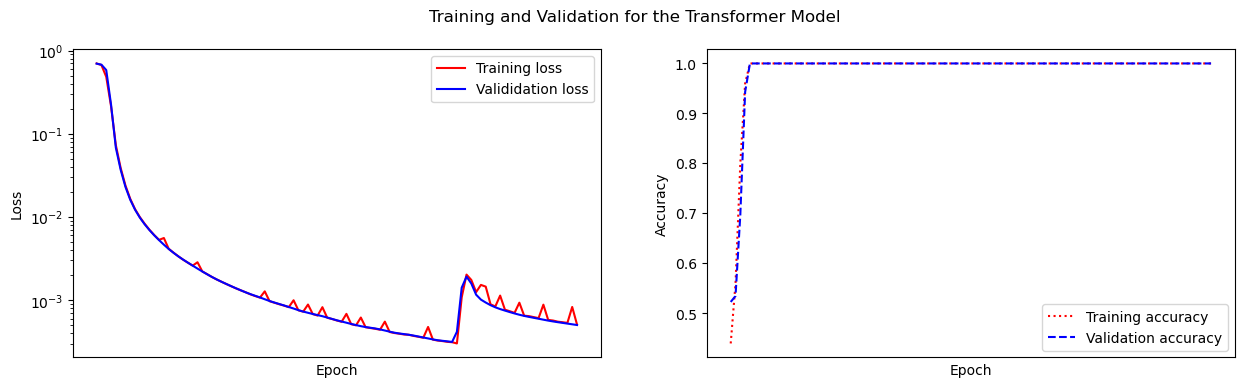

In [32]:
plt.figure(figsize=(15, 4))
plt.suptitle("Training and Validation for the Transformer Model")
plt.subplot(1, 2, 1)
plt.plot(t_loss, label="Training loss", color="red")
plt.plot(v_loss, label="Valididation loss", color="blue")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([])
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(t_acc, label="Training accuracy", color="red", linestyle="dotted")
plt.plot(v_acc, label="Validation accuracy", color="blue", linestyle="--")
plt.xticks([])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [33]:
correct_ids = data_gen.f_i
print(f"Target indices: {correct_ids}")

Target indices: [3, 9, 19]


In [34]:
B_plot = 10
X_plot, y_plot = data_gen.generate(B_plot, split="valid", verbose=True)

Data-label balance: 0.4000000059604645


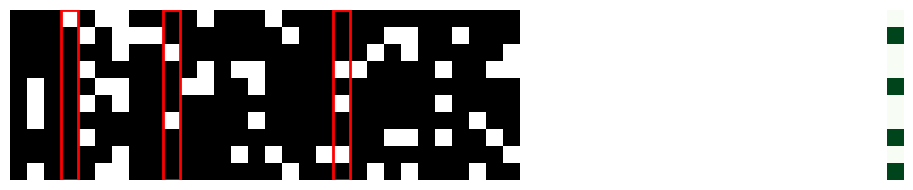

In [35]:
import matplotlib.gridspec as gridspec
fig, axs = plt.subplots(1, 2, figsize=(16,2), sharey=True)
rects = []
for ri in correct_ids:
    rects.append(plt.Rectangle((ri-0.5, -0.5), 1, B_plot, edgecolor="red", alpha=1.0, fill=False, linewidth=2))
axs[0].imshow(X_plot, cmap="binary")
for rect in rects:
    axs[0].add_patch(rect)
axs[0].axis("off")
axs[1].imshow(y_plot, cmap="Greens")
axs[1].axis("off")
plt.tight_layout()
plt.show()

In [36]:
with torch.no_grad():
    o_emb = model.embed(X_plot.to(device)).cpu().detach()
    o_att = model.attend(o_emb.to(device)).cpu().detach()

In [37]:
o_att.shape

torch.Size([10, 16, 31, 31])

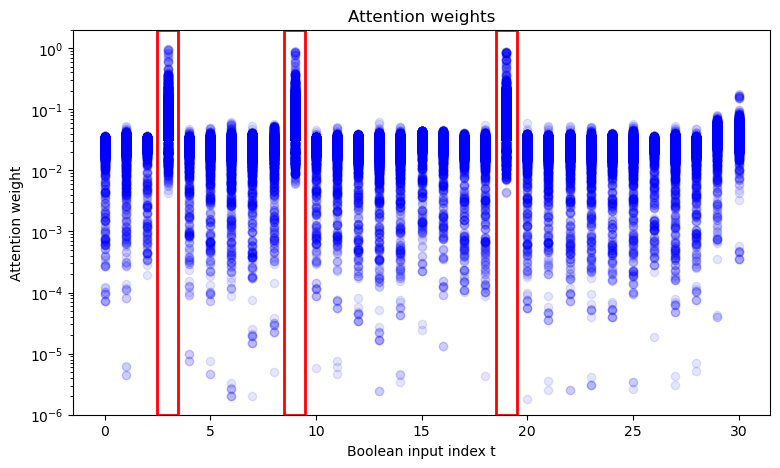

In [38]:
o_att_flatten = o_att.view(-1, T+1)
n_weights = o_att_flatten.size(0)
fig, ax = plt.subplots(figsize=(9, 5))
for i in range(T+1):
    ax.scatter(torch.full((n_weights, ), i) , o_att_flatten[:, i], alpha=0.1, c='blue')
rects = []
for ri in correct_ids:
    rects.append(plt.Rectangle((ri-0.5, 1e-6), 1.0, 2.0, edgecolor="red", alpha=1.0, fill=False, linewidth=2))
for rect in rects:
    ax.add_patch(rect)
plt.yscale("log")
plt.ylim(1e-6, 2)
plt.title("Attention weights")
plt.xlabel("Boolean input index t")
plt.ylabel("Attention weight")
plt.show()

In [39]:
class BinaryMLP(torch.nn.Module):
    def __init__(self, in_dims, h_dims, out_dims, dropout=0.1):
        super().__init__()
        self.in_dims = in_dims
        self.h_dims = h_dims
        self.out_dims = out_dims

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(in_dims, h_dims[0]))
        torch.nn.init.normal_(self.layers[-1].weight, std=0.02)
        torch.nn.init.zeros_(self.layers[-1].bias)
        self.layers.append(torch.nn.GELU())
        self.layers.append(torch.nn.Dropout(dropout))
        for i in range(len(h_dims) - 1):
            self.layers.append(torch.nn.Linear(h_dims[i], h_dims[i+1]))
            torch.nn.init.normal_(self.layers[-1].weight, std=0.02)
            torch.nn.init.zeros_(self.layers[-1].bias)
            self.layers.append(torch.nn.GELU())
            self.layers.append(torch.nn.Dropout(dropout))
        self.layers.append(torch.nn.Linear(h_dims[-1], out_dims))
        self.layers.append(torch.nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [62]:
T = 30  # context length
s = 3  # sparsity
B_t = 50  # batch size for training
B_v = 500  # batch size for validation
data_gen = OneDAnd(T, s)
X_t, y_t = data_gen.generate(B_t, split="train", verbose=True)
X_v, y_v = data_gen.generate(B_v, split="valid", verbose=True)
correct_ids = data_gen.f_i
print(f"Target indices: {correct_ids}")


Data-label balance: 0.47999998927116394
Data-label balance: 0.4860000014305115
Target indices: [14, 22, 29]


In [63]:
mlp_model = BinaryMLP(T, [128, 128], 1)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
criterion = torch.nn.BCELoss()
print(f"Number of parameters: {get_n_parameters(mlp_model)}")


Number of parameters: 20609


In [64]:
n_epochs = 1000
t_loss, v_loss, t_acc, v_acc = trainer(mlp_model, optimizer, criterion, n_epochs, X_t.float(), y_t, X_v.float(), y_v, device=device, verbose=True)

Epoch 0001: Train loss: 0.691698 acc: 0.520 Valid loss: 0.691998 acc: 0.526
Epoch 0010: Train loss: 0.619129 acc: 0.900 Valid loss: 0.658745 acc: 0.750
Epoch 0020: Train loss: 0.454448 acc: 0.980 Valid loss: 0.583966 acc: 0.776
Epoch 0030: Train loss: 0.214118 acc: 0.980 Valid loss: 0.468524 acc: 0.788
Epoch 0040: Train loss: 0.059495 acc: 1.000 Valid loss: 0.408876 acc: 0.814
Epoch 0050: Train loss: 0.015648 acc: 1.000 Valid loss: 0.431852 acc: 0.816
Epoch 0060: Train loss: 0.005547 acc: 1.000 Valid loss: 0.468689 acc: 0.810
Epoch 0070: Train loss: 0.002940 acc: 1.000 Valid loss: 0.490565 acc: 0.812
Epoch 0080: Train loss: 0.001972 acc: 1.000 Valid loss: 0.501631 acc: 0.814
Epoch 0090: Train loss: 0.001527 acc: 1.000 Valid loss: 0.508621 acc: 0.818
Epoch 0100: Train loss: 0.001281 acc: 1.000 Valid loss: 0.513539 acc: 0.820
Epoch 0110: Train loss: 0.001119 acc: 1.000 Valid loss: 0.517308 acc: 0.820
Epoch 0120: Train loss: 0.000999 acc: 1.000 Valid loss: 0.520547 acc: 0.820
Epoch 0130: 

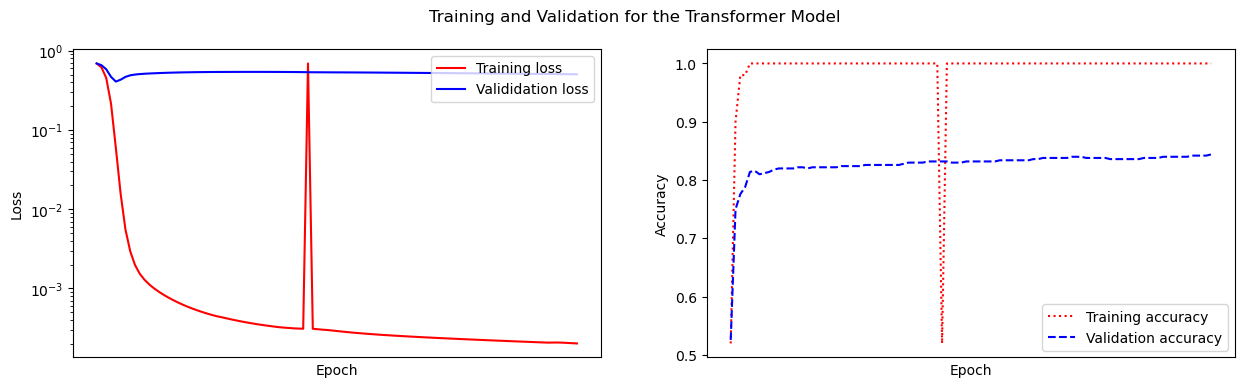

In [65]:
plt.figure(figsize=(15, 4))
plt.suptitle("Training and Validation for the Transformer Model")
plt.subplot(1, 2, 1)
plt.plot(t_loss, label="Training loss", color="red")
plt.plot(v_loss, label="Valididation loss", color="blue")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([])
plt.legend(loc="upper right")
plt.subplot(1, 2, 2)
plt.plot(t_acc, label="Training accuracy", color="red", linestyle="dotted")
plt.plot(v_acc, label="Validation accuracy", color="blue", linestyle="--")
plt.xticks([])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

In [45]:
X_test, y_test = data_gen.generate(B_v, split="test", verbose=True)
evaluator(model, criterion, X_test, y_test, device="cpu")

Data-label balance: 0.5120000243186951


(2.8415274620056152, 0.626)